In [ ]:
# 한국어 원문 데이터(법원 판결문 요약문)를 classification: '일반행정', '세무', '특허', '형사', '민사', '가사'
# 데이터 출처 > https://aihub.or.kr/aidata/8054
# LSTM 모델 사용

In [2]:
!pip install --upgrade aiohttp

In [3]:
!pip install tensorflow

### 1. 데이터 읽기

In [18]:
import matplotlib.font_manager as fm

font_list = fm.findSystemFonts(fontpaths = None, fontext = 'ttf')
font_list[:]

['/System/Library/Fonts/Supplemental/PlantagenetCherokee.ttf',
 '/System/Library/AssetsV2/com_apple_MobileAsset_Font7/a3f9a9e35bdf3babe03b2fd162051306fad439d6.asset/AssetData/Osaka.ttf',
 '/System/Library/AssetsV2/com_apple_MobileAsset_Font7/5b843781be7f58151ada774942a0eaa9ec79bd57.asset/AssetData/Kyokasho.ttc',
 '/System/Library/Fonts/Supplemental/Verdana Italic.ttf',
 '/System/Library/Fonts/SFCamera.ttf',
 '/System/Library/AssetsV2/com_apple_MobileAsset_Font7/256f90b4f23b30e5356a8e7c2e239a8d53a48e8c.asset/AssetData/Maku-Devanagari.ttc',
 '/System/Library/AssetsV2/com_apple_MobileAsset_Font7/34fead973f6b219177a77839ad8f341551fc495f.asset/AssetData/Niramit.ttc',
 '/System/Library/Fonts/Supplemental/STIXNonUniBol.otf',
 '/System/Library/Fonts/Supplemental/Copperplate.ttc',
 '/System/Library/AssetsV2/com_apple_MobileAsset_Font7/1b3d20c129476a1c955d799d5b449ba927728923.asset/AssetData/BalooPaajiGurmukhi.ttc',
 '/System/Library/AssetsV2/com_apple_MobileAsset_Font7/eb06f5c216ccc3eed69b7d653

In [17]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns

tf.random.set_seed(0)

font_dirs = '/System/Library/Fonts/Supplemental/AppleGothic.ttf'
font = fm.FontProperties(fname = font_dirs).get_name()
    
plt.rc('font', family=font) 

In [19]:
fp = './project_data_all3.json'
df = pd.read_json(fp) # json to dataframe

In [20]:
df.head()

,id,category,size,char_count,publish_date,title,text,annotator_id,document_quality_scores,extractive,abstractive
0,83587,일반행정,small,509,20041125,사도개설허가취소신청거부처분취소,"[[{'index': 0, 'sentence': '[1] 취소소송은 처분 등이 있음...",3852,"{'readable': 3, 'accurate': 4, 'informative': ...","[0, 4, 6]","[취소소송은 처분 등이 있다는 것을 안 때로부터 90일 이내에 제기하여야 하고, 행..."
1,83588,일반행정,medium,845,20041126,노선배분취소처분취소·국제선정기항공운송사업노선면허거부처분취소,"[[{'index': 0, 'sentence': '[1] 항고소송의 대상이 되는 행...",3814,"{'readable': 4, 'accurate': 4, 'informative': ...","[0, 4, 9]",[항고소송의 대상이 되는 행정처분이란 일반 국민의 권리의무에 직접 영향을 미치는 행...
2,83590,세무,small,425,20041125,취득세부과처분취소,"[[{'index': 0, 'sentence': '취득세는 본래 재화의 이전이라는 ...",3710,"{'readable': 3, 'accurate': 3, 'informative': ...","[1, 2, 3]","[취득세는 사실상의 취득행위 자체를 과세객체로 하고, 지방세법에 따르면 부동산 취득..."
3,83591,세무,small,292,20041126,관세부과처분취소,"[[{'index': 0, 'sentence': '[1] 행정처분이 당연무효라고 하...",3708,"{'readable': 3, 'accurate': 3, 'informative': ...","[0, 1, 5]","[행정처분이 당연무효라고 하기 위해서는 하자가 중대, 명백해야 하는데 세관출장소장이..."
4,83592,특허,small,275,20041126,거절결정(상),"[[{'index': 0, 'sentence': '[1] 등록출원한 상표가 상표법 ...",4255,"{'readable': 5, 'accurate': 5, 'informative': ...","[0, 1, 3]",[상표법에 따라 상표가 등록받을 수 있는지의 여부는 구체적으로 판단하므로 출원상표 ...


In [21]:
df.category.unique() # class = 6

array(['일반행정', '세무', '특허', '형사', '민사', '가사'], dtype=object)

fig, axe = plt.subplots(ncols=1)
sns.countplot(x='category', data=df)

# raw data의 분포가 불균형함을 확인한다. train_test_split 메소드에서 stratify 옵션을 활용한다.

In [38]:
# for classification, digitize cateogry strings, and they are 'target'.
df['category'] = df['category'].replace({'가사': 0, '형사': 1, '특허': 2, '민사': 3, '일반행정': 4, '세무': 5})
target = df['category'].values

data = df['abstractive'].values # we have to analyze - natural data!
# 목표: data(자연어 데이터)를 보고 target 예측

In [39]:
print(len(target))
print(len(data))

3004
3004


In [40]:
pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 27.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.4/587.4 kB 30.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


### 2. 형태소 분석

In [51]:
# KoNLPy - Okt 클래스 사용
# stemming기반의 형태소 분석 -> 어간을 분리함
from konlpy.tag import Okt

In [45]:
okt = Okt()
pos_results = okt.pos(data[0][0], norm = True, stem = True)
# okt.pos: 각 품사를 태깅한다.
print(data[0][0])
print()
print(pos_results)

취소소송은 처분 등이 있다는 것을 안 때로부터 90일 이내에 제기하여야 하고, 행정처분에서의 허가에 붙은 기한이 부당하게 짧은 경우에는 이를 허가조건 존속기간으로 보아서 그 기한의 도래로 조건 개정을 고려한다고 해석할 수 있기에, 사도개설허가의 준공검사를 받지 못한 것은 사도개설허가 자체의 존속기간으로 볼 수 없다는 까닭으로 이것이 실효되는 것은 아니다.

[('취소소송', 'Noun'), ('은', 'Josa'), ('처분', 'Noun'), ('등', 'Noun'), ('이', 'Josa'), ('있다', 'Adjective'), ('것', 'Noun'), ('을', 'Josa'), ('안', 'Noun'), ('때', 'Noun'), ('로부터', 'Noun'), ('90일', 'Number'), ('이내', 'Noun'), ('에', 'Josa'), ('제기', 'Noun'), ('하다', 'Verb'), ('하다', 'Verb'), (',', 'Punctuation'), ('행정처분', 'Noun'), ('에서의', 'Josa'), ('허가', 'Noun'), ('에', 'Josa'), ('붙다', 'Verb'), ('기한', 'Noun'), ('이', 'Josa'), ('부당하다', 'Adjective'), ('짧다', 'Adjective'), ('경우', 'Noun'), ('에는', 'Josa'), ('이르다', 'Verb'), ('허가', 'Noun'), ('조건', 'Noun'), ('존속', 'Noun'), ('기간', 'Noun'), ('으로', 'Josa'), ('보아', 'Noun'), ('서', 'Josa'), ('그', 'Noun'), ('기한', 'Noun'), ('의', 'Josa'), ('도래', 'Noun'), ('로', 'Josa'), ('조건', 'Noun'), ('개정', 'Noun'), ('을', 'Josa'), ('고려', 'Noun'), ('하다', 'Verb'), ('해석', 'Noun'), ('하다', 'Verb

In [48]:
data_tokenized = []

for text in data:
    data_tokenized.append(okt.nouns(text[0]))

In [49]:
print(data_tokenized[0])

['취소소송', '처분', '등', '것', '안', '때', '로부터', '이내', '제기', '행정처분', '허가', '기한', '경우', '허가', '조건', '존속', '기간', '보아', '그', '기한', '도래', '조건', '개정', '고려', '해석', '수', '사도', '개설', '허가', '준공', '검사', '못', '것', '사도', '개설', '허가', '자체', '존속', '기간', '볼', '수', '까닭', '것', '실효', '것']


판결 요약문의 최대 길이 :150
판결 요약문의 평균 길이 :43.73601864181092


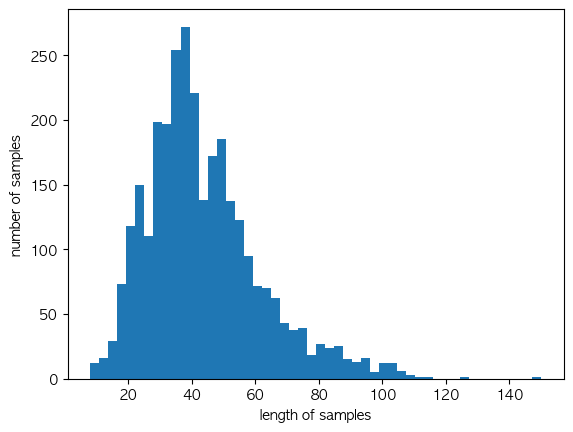

In [50]:
print('판결 요약문의 최대 길이 :{}'.format(max(len(l) for l in data_tokenized)))
print('판결 요약문의 평균 길이 :{}'.format(sum(map(len, data_tokenized))/len(data_tokenized)))

plt.hist([len(s) for s in data_tokenized], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### 3. Keras의 텍스트 전처리

In [56]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_tokenized)
# 형태소 분석까지 완료된 데이터를 빈도수를 기준으로 인덱스를 부여한다: 0이 가장 큰 빈도수를 가지는 단어의 인덱스

In [57]:
print(tokenizer.word_index)

{'제': 1, '것': 2, '수': 3, '그': 4, '경우': 5, '위': 6, '행위': 7, '등': 8, '해당': 9, '관': 10, '법': 11, '대한': 12, '처분': 13, '항': 14, '규정': 15, '사실': 16, '피고인': 17, '및': 18, '이': 19, '볼': 20, '때': 21, '인정': 22, '토지': 23, '원고': 24, '구': 25, '회사': 26, '등기': 27, '후': 28, '청구': 29, '함': 30, '계약': 31, '사업': 32, '대하': 33, '취득': 34, '의무': 35, '목적': 36, '판단': 37, '피고': 38, '시행': 39, '지급': 40, '취소': 41, '판결': 42, '대상': 43, '사용': 44, '위반': 45, '결정': 46, '성립': 47, '위법': 48, '과세': 49, '사건': 50, '사유': 51, '여부': 52, '부동산': 53, '죄': 54, '소유권': 55, '거래': 56, '내용': 57, '사정': 58, '권리': 59, '법률': 60, '이유': 61, '허가': 62, '기간': 63, '절차': 64, '이전': 65, '발생': 66, '양도': 67, '세법': 68, '로서': 69, '채권': 70, '기재': 71, '업무': 72, '재산': 73, '금': 74, '적용': 75, '이익': 76, '변경': 77, '관계': 78, '정': 79, '다른': 80, '중': 81, '상의': 82, '책임': 83, '무효': 84, '손해': 85, '신청': 86, '방법': 87, '자': 88, '호': 89, '보험': 90, '명의': 91, '소송': 92, '부분': 93, '대해': 94, '확정': 95, '이상': 96, '바': 97, '피해자': 98, '상표': 99, '액': 100, '부과': 101, '범위': 102, '법인':

In [59]:
# 빈도수 상위 1000개 단어만 학습에 사용하게 tokenizer 재정의한다
tokenizer = Tokenizer(num_words = 1000)
tokenizer.fit_on_texts(data_tokenized)
data_index = tokenizer.texts_to_sequences(data_tokenized)

In [64]:
data[0][0] # raw data 문장

'취소소송은 처분 등이 있다는 것을 안 때로부터 90일 이내에 제기하여야 하고, 행정처분에서의 허가에 붙은 기한이 부당하게 짧은 경우에는 이를 허가조건 존속기간으로 보아서 그 기한의 도래로 조건 개정을 고려한다고 해석할 수 있기에, 사도개설허가의 준공검사를 받지 못한 것은 사도개설허가 자체의 존속기간으로 볼 수 없다는 까닭으로 이것이 실효되는 것은 아니다.'

In [65]:
data_tokenized[0] # 형태소 분석 중 noun만 모은 것

['취소소송',
 '처분',
 '등',
 '것',
 '안',
 '때',
 '로부터',
 '이내',
 '제기',
 '행정처분',
 '허가',
 '기한',
 '경우',
 '허가',
 '조건',
 '존속',
 '기간',
 '보아',
 '그',
 '기한',
 '도래',
 '조건',
 '개정',
 '고려',
 '해석',
 '수',
 '사도',
 '개설',
 '허가',
 '준공',
 '검사',
 '못',
 '것',
 '사도',
 '개설',
 '허가',
 '자체',
 '존속',
 '기간',
 '볼',
 '수',
 '까닭',
 '것',
 '실효',
 '것']

In [66]:
print(data_index[0]) # 0번째 문장, 형태소 분석한 것을 index화 한것

[13, 8, 2, 394, 21, 197, 992, 124, 227, 62, 411, 5, 62, 301, 606, 63, 113, 4, 411, 301, 344, 219, 147, 3, 569, 62, 666, 272, 357, 2, 569, 62, 210, 606, 63, 20, 3, 2, 993, 2]


### 4. 판결 요약문 분류: LSTM

In [69]:
from tensorflow.keras.datasets import reuters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

X_train, X_test, y_train, y_test = train_test_split(data_index, target, test_size=0.2, stratify=target, random_state=100)

In [70]:
max_len = 40 # from mean of # words

X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [71]:
# one-hot encoding y targets: length 6 vectorize

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [72]:
model = Sequential()
model.add(Embedding(1000, 120)) # 1000개의 단어에 대해 각각 120차원의 임베딩 벡터 생성
model.add(LSTM(120))
model.add(Dense(6, activation='softmax')) # 6 classification

In [74]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5.keras', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [75]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(X_train, y_train, batch_size=128, epochs=30, callbacks=[es, mc], validation_data=(X_test, y_test))

Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - acc: 0.3584 - loss: 1.7014
Epoch 1: val_acc improved from -inf to 0.47754, saving model to best_model.h5.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - acc: 0.3604 - loss: 1.6958 - val_acc: 0.4775 - val_loss: 1.3982
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - acc: 0.4860 - loss: 1.3279
Epoch 2: val_acc improved from 0.47754 to 0.61065, saving model to best_model.h5.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - acc: 0.4888 - loss: 1.3230 - val_acc: 0.6106 - val_loss: 1.0350
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - acc: 0.6475 - loss: 0.9263
Epoch 3: val_acc improved from 0.61065 to 0.68719, saving model to best_model.h5.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - acc: 0.6499 - loss: 0.9216 - val_acc: 0.6872 - val_loss: 0.8632
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - acc: 0.7635 - loss: 0.6670
Epoch 4: val_acc improved from 0.68719 to 0.77704, saving model to best_model.h5.keras
19/19 ━━━━━━━━━━━

In [76]:
loaded_model = load_model('best_model_h5.keras')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'best_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)